In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

import networkx as nx
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn import metrics
from datetime import datetime

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
from original_node2vec import Node2Vec
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

In [3]:
SEED = 42

In [4]:
def count_score(labels, clusters):
    adj_score = metrics.adjusted_rand_score(labels,clusters)
    return adj_score

def make_graph(labels, edges):
    G = nx.Graph()
    G.add_nodes_from(labels['node'])

    for i, row in edges.iterrows():
        G.add_edge(row['from'],row['to'], weight=1)
    return G 

def write_to_file(res,param):
    now = datetime.now()
    current_time = now.strftime('%Y%m%d_one_eighth_'+param)
    filename = '../results/' + current_time + '.csv'
    res.to_csv(filename)
    
def evaluate(n2vtype,
            G, labels,
            dimensions=128,
            walk_length=80,
            num_walks=10,
            p=1.0,
            q=1.0,
            workers=4,
            window=10,
            min_count=1,
            seed=42):
    
    model,model_nodes = count_embeddings(n2vtype,G,
                                         labels,dimensions,
                                         walk_length,num_walks,p,q,workers,
                                         window,min_count,
                                         seed)
    # the list of known labels inthe model nodes order
    known_labels = []
    for i in model.wv.index2word:
        known_labels.append(labels.loc[int(i)]['label'])
        
    n_clusters = len(labels_list)

    # clustering
    km = KMeans(n_clusters=n_clusters).fit_predict(model.wv.vectors)
    
    adj_score = count_score(known_labels, km)
    
    return adj_score

In [5]:
def count_embeddings(n2vtype,G,labels,dimensions=128,
                     walk_length=80,num_walks=10,
                     p=1.0,q=1.0,workers=4,window=10,
                     min_count=1,seed=SEED):
    if n2vtype=='stellar':
        rw = BiasedRandomWalk(StellarGraph.from_networkx(G))
        weighted_walks = rw.run(
            nodes=G.nodes(), # root nodes
            length=walk_length,    # maximum length of a random walk
            n=num_walks,          # number of random walks per root node 
            p=p,         # Defines (unormalised) probability, 1/p, of returning to source node
            q=q,         # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False, #for weighted random walks
            seed=seed        # random seed fixed for reproducibility
        )
#         print("Number of random walks: {}".format(len(weighted_walks)))
        weighted_walks = [[str(j) for j in i] for i in weighted_walks] # int into str
        
        model = Word2Vec(weighted_walks, 
                     size=dimensions, 
                     window=window, 
                     min_count=0, 
                     sg=1, 
                     workers=1, 
                     iter=1)
    if n2vtype=='original':
        n2v = Node2Vec(G, 
                   dimensions = dimensions, 
                   walk_length = walk_length,
                   num_walks = num_walks,
                   p = p,
                   q = q,
                   workers = workers
                  )
        model = n2v.fit(window = window, 
                        min_count = min_count,
                        seed = seed
                       )
    model_nodes = list(model.wv.vocab)

    return model,model_nodes

# Data reading

In [6]:
edges = pd.read_csv('../data/clear_cluster_test/one_eighth.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, names=('node','label'))
labels = labels.sort_values(by='label')

labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

G = make_graph(labels, edges)

In [7]:
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True, seed=SEED)

C:\Users\Adeliia\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [8]:
start = time.time()
score_org = evaluate('original',G,labels)
end = time.time()
print(end - start)

start = time.time()
score_stel = evaluate('stellar',G,labels)
end = time.time()
print(end - start)

print(score_org, score_stel)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 2501.31it/s]


5.79418420791626
0.720740556716919
0.4883720930232558 0.44014084507042256


In [9]:
start = time.time()
score_org = evaluate('original',G,labels,p=0.5,q=2.0)
end = time.time()
print(end - start)

start = time.time()
score_stel = evaluate('stellar',G,labels,p=0.5,q=2.0)
end = time.time()
print(end - start)

print(score_org, score_stel)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 2786.17it/s]


0.6506736278533936
0.6676228046417236
0.8928571428571429 0.7874015748031497


In [10]:
start = time.time()
score_org = evaluate('original',G,labels,walk_length=100,p=0.5,q=2.0,window=5)
end = time.time()
print(end - start)

start = time.time()
score_stel = evaluate('stellar',G,labels,walk_length=100,p=0.5,q=2.0,window=5)
end = time.time()
print(end - start)

print(score_org, score_stel)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 3563.92it/s]


0.7243244647979736
0.7913167476654053
1.0 1.0


## Parameters sensitivity (on previously calculated results)

In [11]:
res_dim = pd.read_csv('../results/20200506_one_eighth_dimensions.csv')
res_walk_length = pd.read_csv('../results/20200506_one_eighth_walk_length.csv')
res_num_walks = pd.read_csv('../results/20200506_one_eighth_num_walks.csv')
res_p = pd.read_csv('../results/20200506_one_eighth_p.csv')
res_q = pd.read_csv('../results/20200506_one_eighth_q.csv')
res_window = pd.read_csv('../results/20200506_one_eighth_window.csv')

x1 = res_dim['dimensions']
y1 = res_dim['adj_rand'].tolist()

x2 = res_walk_length['walk_length']
y2 = res_walk_length['adj_rand'].tolist()

x3 = res_num_walks['num_walks']
y3 = res_num_walks['adj_rand'].tolist()

x4 = res_p['p']
y4 = res_p['adj_rand'].tolist()

x5 = res_q['q']
y5 = res_q['adj_rand'].tolist()

x6 = res_window['window']
y6 = res_window['adj_rand'].tolist()

In [12]:
res_dim_stel = pd.read_csv('../results/20200525_one_eighth_stellar_dimensions.csv')
res_walk_length_stel = pd.read_csv('../results/20200525_one_eighth_stellar_walk_length.csv')
res_num_walks_stel = pd.read_csv('../results/20200525_one_eighth_stellar_num_walks.csv')
res_p_stel = pd.read_csv('../results/20200525_one_eighth_stellar_p.csv')
res_q_stel = pd.read_csv('../results/20200525_one_eighth_stellar_q.csv')
res_window_stel = pd.read_csv('../results/20200525_one_eighth_stellar_window.csv')

x1_stel = res_dim_stel['dimensions']
y1_stel = res_dim_stel['adj_rand'].tolist()

x2_stel = res_walk_length_stel['walk_length']
y2_stel = res_walk_length_stel['adj_rand'].tolist()

x3_stel = res_num_walks_stel['num_walks']
y3_stel = res_num_walks_stel['adj_rand'].tolist()

x4_stel = res_p_stel['p']
y4_stel = res_p_stel['adj_rand'].tolist()

x5_stel = res_q_stel['q']
y5_stel = res_q_stel['adj_rand'].tolist()

x6_stel = res_window_stel['window']
y6_stel = res_window_stel['adj_rand'].tolist()

In [13]:
def show_both_params():
    plt.figure(figsize=[15,13])

    plt.subplot(331)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x2,y2,'ro--', label='RAND org')
    plt.plot(x2_stel,y2_stel,'o-', label='RAND stellar')
    plt.legend(loc='best', frameon=True)
    plt.xlabel('walk_length')
    plt.ylabel('score')

    plt.subplot(332)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x3,y3,'ro--', label='RAND org')
    plt.plot(x3_stel,y3_stel,'o-', label='RAND stellar')
    plt.legend(loc='best', frameon=True)
    plt.xlabel('num_walks')
    plt.ylabel('score')

    plt.subplot(333)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x4,y4,'ro--', label='RAND org')
    plt.plot(x4_stel,y4_stel,'o-', label='RAND stellar')
    plt.xscale('log', basex=2)
    plt.legend(loc='best', frameon=True)
    plt.xlabel('p')
    plt.ylabel('score')

    plt.subplot(334)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x5,y5,'ro--', label='RAND org')
    plt.plot(x5_stel,y5_stel,'o-', label='RAND stellar')
    plt.xscale('log', basex=2)
    plt.legend(loc='best', frameon=True)
    plt.xlabel('q')
    plt.ylabel('score')
    
    plt.subplot(335)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x1,y1,'ro--', label='RAND org')
    plt.plot(x1_stel,y1_stel,'o-', label='RAND stellar')
    plt.xscale('log', basex=2)
    plt.legend(loc='best', frameon=True)
    plt.xlabel('dimensions')
    plt.ylabel('score')

    plt.subplot(336)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(x6,y6,'ro--', label='RAND org')
    plt.plot(x6_stel,y6_stel,'o-', label='RAND stellar')
    plt.legend(loc='best', frameon=True)
    plt.xlabel('window')
    plt.ylabel('score')

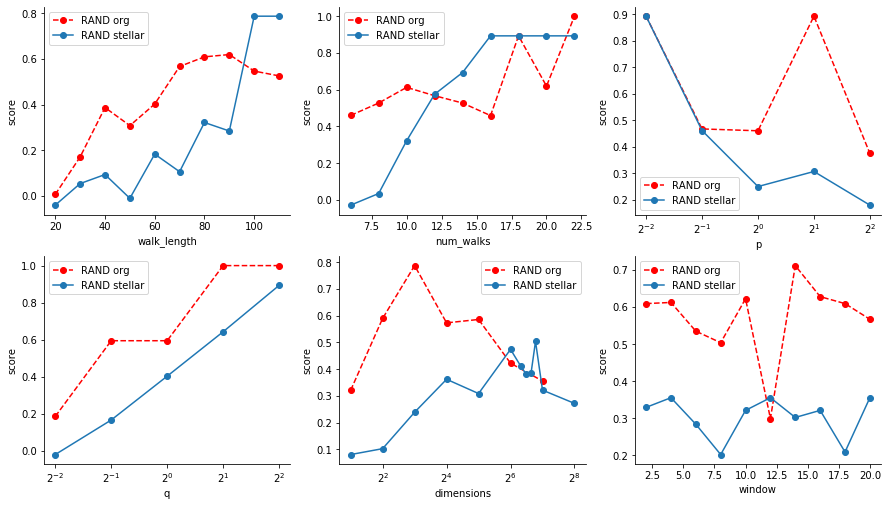

In [14]:
show_both_params()